In [110]:
import numpy as np
import pandas as pd
from scipy.stats import norm, multivariate_normal
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

np.random.seed(1) # For reproducibility

In [40]:
start_date = dt.strptime("2017-01-01", "%Y-%m-%d").date()
num_years = 3
max_date = start_date + relativedelta(years=num_years, days=-1)

days = [start_date]
while days[-1] < max_date:
    days.append(
        days[-1] + relativedelta(days=1))

In [87]:
# Put date in data frame
df = pd.DataFrame({"day": days})

# Simple transformations
df = df.assign(
    intercept=1.,
    day_of_week=df.day.apply(lambda d: d.weekday()),
    days_since_start=df.day.apply(lambda d: (d - start_date).days),
    day_of_year=df.day.apply(lambda d: d.timetuple().tm_yday),
)

# Small modifications to transformations
df = df.assign(
    days_since_start=(df.days_since_start - df.days_since_start.mean()) /
        df.days_since_start.std(), # Rescaling
    year_radians=df.day_of_year*2*np.pi/365,
)

In [95]:
# Day of week
day_of_week_dummies = pd.get_dummies(df.day_of_week, prefix="day_of_week")

# Long-term trends
trends = (df
    .assign(days_since_start_squared=df.days_since_start**2)
    .loc[:, ["days_since_start", "days_since_start_squared"]]
)

# Seasonality
seasonality = df.assign(
    seasonality_cos=np.cos(df.year_radians),
    seasonality_sin=np.sin(df.year_radians)).loc[
    :, ["seasonality_cos", "seasonality_sin"]
]

In [105]:
# Create design matrix
df_list = [
    df.loc[:, ["intercept"]],
    day_of_week_dummies,
    long_term_trends,
    seasonality,
]

X_df = pd.concat(df_list, axis=1)
X = X_df.values

(1095, 12)

In [132]:
# Set beta
beta_intercept = [3.]
beta_day_of_week = [-0.3, 0.03, 0.06, 0.1, 0.09, -0.04, -0.23]
beta_trends = [0.4, -0.17]
beta_seasonality = [0.2, -0.1]
beta = np.array(
    beta_intercept +
        beta_day_of_week +
        beta_trends +
        beta_seasonality)

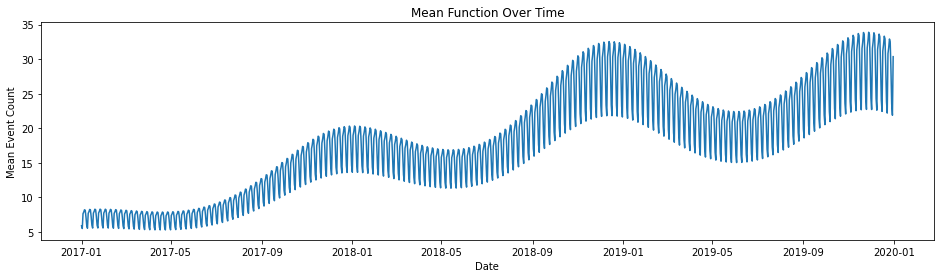

In [135]:
# Explore mean relationship
mu = X @ beta
exp_mu = np.exp(mu)
from matplotlib.pyplot import figure

plt.figure(figsize=(16, 4))
plt.plot(
    df.day,
    exp_mu,
)
plt.xlabel("Date")
plt.ylabel("Mean Event Count")
plt.title("Mean Function Over Time")
plt.show()